# Processing pipeline - PV solar cell output data

## Modify system path and import pipeline module

In [1]:
from sys import path as syspath
syspath.insert(1, '../src/')

In [2]:
import pandas as pd
from scripts import (process_data, calculations,
                     apply_filters, plotting)

## Define paths to data files (output, environmental, & panel capacity)

In [3]:
# PARK 1 #
root_path = "../data/raw/New_data/"
power_filepath = root_path + "SolarPark1_Jun_2019_Jun2020_string_production.csv"
environment_filepath = root_path + "SolarPark1_Jun_2019_Jun2020_environmental.csv"
capacity_filepath = root_path + "Solarpark_1_string_capacity.csv"

In [4]:
# # PARK 2 #
# root_path = "../data/raw/New_data/"
# power_filepath, \
# capacity_filepath, \
# environment_filepath = [root_path + i for i in ['SolarPark2_Oct_2019_Oct2020_string_production.csv',
#                            'Solarpark_2_CB_capacity.csv',
#                            'Solarpark2_Oct_2019_Oct2020_environmental.csv']]

#### Set output directory for files to be saved

In [5]:
working_dir = "../data/temp/park1/" # will save all interim files here
# working_dir = "../data/temp/park2/" # will save all interim files here

## Run processing pipeline

##### Note that two dataframes are created in the process by the function.

- **Dataframe 1**: the original output with NAs filtered (by irradiance) & environmental data optionally appended.
  
  *Set keep_env_info to True if you want to keep the environmental data in this dataframe.*
  

- **Dataframe 2**: calculated performance ratios with NAs filtered

In [6]:
df, df_PR = process_data.preprocess_data(
    power_filepath,
    environment_filepath,
    capacity_filepath,
    yearly_degradation_rate = 0.005,
    keep_env_info = False,
    save_dir = working_dir
)

Data read successfully.

Columns renamed.
Merged DFs.
Adjusting expected power by degradation rate of: 0.5%/year...
Calculated performance ratio.
(112584, 330)
(57991, 330)
Cleaned dataframes.


Saving dataframes...
	Saving ../data/temp/park1/preprocessing/df_output.csv...
	Done.
	Saving ../data/temp/park1/preprocessing/df_PR.csv...
	Done.
DONE.


## Drop worst strings based on UMAP clustering

### (Need to cluster first and save labels of worst strings to filter out)

In [7]:
cluster_filepath = '../data/processed/park1/park1_string_clusters_filtered.csv'

In [8]:
df_clusters = pd.read_csv(cluster_filepath, delimiter=',')

bottom_cluster = df_clusters['bottom'].dropna().tolist()

df_PR = df_PR.drop(
    columns = [
        i+"_(kW)" for i in bottom_cluster] + [
        col for col in df_PR.columns.to_list(
        ) if col.startswith(
            "ST 2.7") or col.startswith(
            "ST 2.5.4")or col.startswith(
            "ST 4.4.1") or col.startswith(
            "ST 4.5.2")])

## Filter best time periods & strings

Best time window needs to first be determined by ...

In [9]:
#plotting.plot_EPI_daily_window(apply_filters.add_temporal(df_PR, drop_extra = False))
#should do this AFTER filtering strings...?

In [10]:
#plotting.plot_EPI_dpm(apply_filters.add_temporal(df_PR, drop_extra = False))

In [11]:
#plotting.plot_EPI_sd_daily_windows(apply_filters.add_temporal(df_PR, drop_extra = False))

### Set decided time window

In [12]:
peak_hour_start = "15" #park 1 - "15", park 2 - "16"
peak_hour_end = "19" #park 1 - "19", park 2 - "18"

### Run filtering steps

In [13]:
df_BDfilt_dayfilt_hour, \
df_BDfilt_dayfilt_day, \
debug = apply_filters.filter_data(df_PR,
                                 window_start = peak_hour_start,
                                 window_end = peak_hour_end,
                                 save_dir = working_dir)

Beginning filtering...
Filtering time window (15-19)...


/Users/mlindberg/opt/anaconda3/envs/pv_energy/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Shifting daily aggregated data?
Finding thresholds...
Generating boolean masks...
Filtering drops...
Filtering bad days...
Filtering strings in daily aggregated data?
Converting daily agg. back to hourly...
Saving dataframes...
	Saving ../data/temp/park1/filtered/df_PR_timemasked.csv...
	Done.
	Saving ../data/temp/park1/filtered/drops_filt.csv...
	Done.
	Saving ../data/temp/park1/filtered/df_BDfilt_dayfilt_hour.csv...
	Done.
	Saving ../data/temp/park1/filtered/df_BDfilt_dayfilt_day.csv...
	Done.
	Saving ../data/temp/park1/masks/df_bool_d.csv...
	Done.
	Saving ../data/temp/park1/masks/stringmask.csv...
	Done.
	Saving ../data/temp/park1/masks/stringmask2.csv...
	Done.
	Saving ../data/temp/park1/thresholds/description_dailyagg_lag.csv...
	Done.
	Saving ../data/temp/park1/thresholds/description_dailyagg_lead.csv...
	Done.
	Saving ../data/temp/park1/thresholds/leaddf_d.csv...
	Done.
	Saving ../data/temp/park1/thresholds/lagdf_d.csv...
	Done.
Done.


<AxesSubplot:xlabel='datetime'>

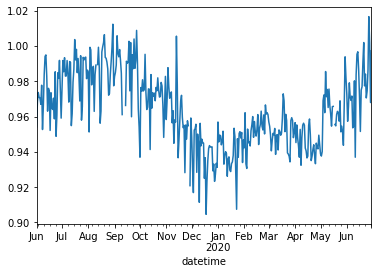

In [22]:
df_BDfilt_dayfilt_day.mean(axis=1).plot(legend=False)

<AxesSubplot:xlabel='datetime'>

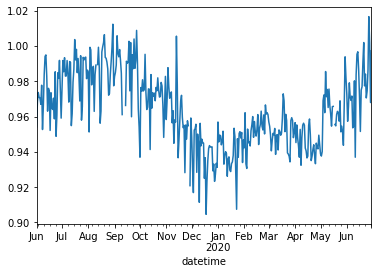

In [23]:
df_BDfilt_dayfilt_day.mean(axis=1).plot(legend=False)

### Estimate soiling

In [ ]:
tmp = pd.read_csv("../data/processed/park1/df_park1_allfilters_hourly_timemasked.csv")
tmp['datetime'] = pd.to_datetime(tmp['datetime'])
tmp = tmp.set_index('datetime')

<AxesSubplot:>

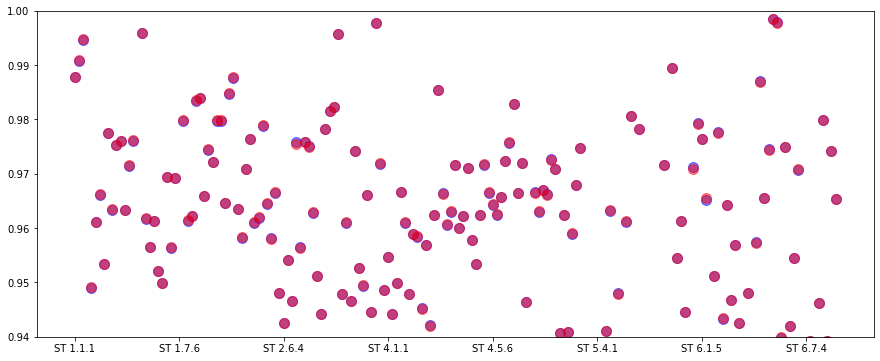

In [96]:
tmp.median().plot(figsize = (15,6), color = "blue", alpha = 0.5, ms=20, use_index = True, style ='.', ylim = (0.94,1))
df_BDfilt_dayfilt_hour.median().plot(use_index=False, color = "red", style = ".", ms=20, alpha = 0.5)

In [76]:
tmp.median(axis=0).mean() -  df_BDfilt_dayfilt_hour.median(axis=0).median()

-0.002447992312067715

In [75]:
4.406552374713879e-05 * 100

0.004406552374713879